In [1]:
from datetime import date
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

### PLOTING ALL DATA and DATA DESCRIPTION

In [119]:
tickers_all = ["ANTM.JK","ASII.JK","ICBP.JK","JSMR.JK"]

today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'

panel_data = data.DataReader(tickers_all,'yahoo',start_date, end_date)
data_close = panel_data["Close"]
data_close.head(5).round(2)

Symbols,ANTM.JK,ASII.JK,ICBP.JK,JSMR.JK
Date,,,,
2010-01-04,1931.95,3530.0,1837.5,1845.68
2010-01-05,1931.95,3550.0,1875.0,1865.63
2010-01-06,1931.95,3530.0,1862.5,1875.61
2010-01-07,1973.95,3420.0,1875.0,1865.63
2010-01-08,1973.95,3440.0,1887.5,1855.65


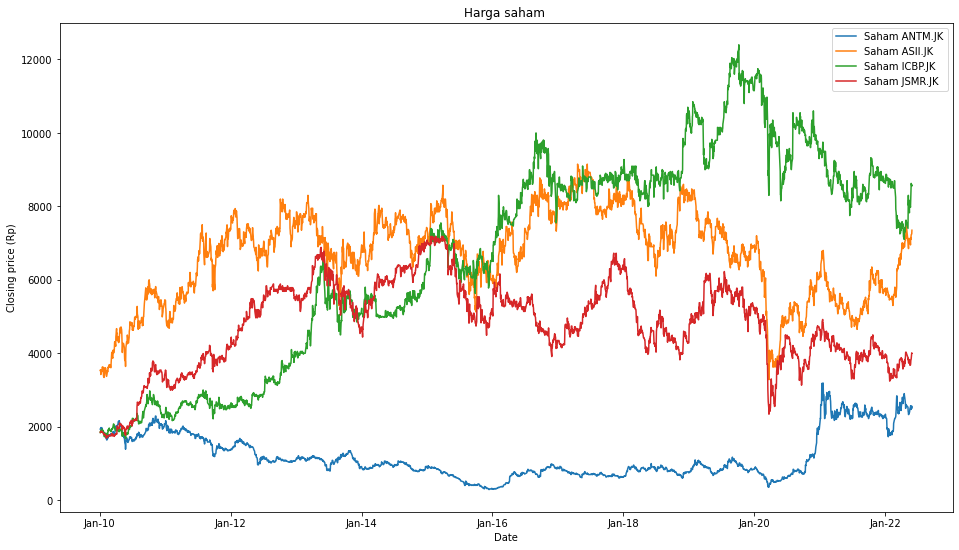

In [120]:
# Plot everything by leveraging the very powerful matplotlib package
fig, ax = plt.subplots(figsize=(16,9))

for name in tickers_all:
    ax.plot(data_close[name].index, data_close[name], label='Saham {}'.format(name))


# Define the date format
date_form = DateFormatter("%b-%y")
ax.xaxis.set_major_formatter(date_form)

ax.set_title('Harga saham ')
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (Rp)')
ax.legend()

Create dataset function

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


## LSTM ONE LAYER

### ANTM

#### GETTING THE DATA AND DATA MANIPULATION

In [245]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ANTM.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetAntm = dataframe.values
datasetAntm = datasetAntm.astype('float32')
datasetAntm
#print(all_weekdays)



array([[1931.9468],
       [1931.9468],
       [1931.9468],
       ...,
       [2470.    ],
       [2560.    ],
       [2510.    ]], dtype=float32)

#### NORMALIZE THE DATA

In [246]:
# normalize the datasetAntm
scaler = MinMaxScaler(feature_range=(0, 1))
datasetAntm = scaler.fit_transform(datasetAntm)
# split into train and test sets
train_size = int(len(datasetAntm) * 0.67)
test_size = len(datasetAntm) - train_size
train_antm, test_antm = datasetAntm[0:train_size,:], datasetAntm[train_size:len(datasetAntm),:]

In [247]:
# reshape into X=t and Y=t+1
look_back = 2
trainXAntm, trainYAntm = create_dataset(train_antm, look_back)
testXAntm, testYAntm = create_dataset(test_antm, look_back)
# reshape input to be [samples, time steps, features]
trainXAntm = np.reshape(trainXAntm, (trainXAntm.shape[0], trainXAntm.shape[1], 1))
testXAntm = np.reshape(testXAntm, (testXAntm.shape[0], testXAntm.shape[1], 1))

#### MODEL DEFINITION

In [248]:
import random
random.seed(2)
# create and fit the LSTM network

modelAntmOne = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='relu', input_shape=(look_back, 1)),
tf.keras.layers.Dense(1)
])
modelAntmOne.summary()
modelAntmOne.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelAntmOneHistory = modelAntmOne.fit(trainXAntm, trainYAntm, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_64 (LSTM)              (None, 64)                16896     
                                                                 
 dense_36 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 2s 12ms/step - loss: 0.2054 - mean_absolute_error: 0.2054 - val_loss: 0.0254 - val_mean_absolute_error: 0.0254
Epoch 2/10
52/52 [==============================] - 0s 4ms/step - loss: 0.0564 - mean_absolute_error: 0.0564 - val_loss: 0.0102 - val_mean_absolute_error: 0.0102
Epoch 3/10
52/52 [==============================] - 0s 5ms/step - loss: 0.0097 - mean_absolute_error: 0.0097 - val_loss:

#### PLOT MODEL LOSS

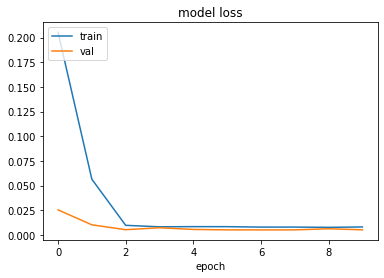

In [249]:
plt.plot(modelAntmOneHistory.history['loss'])
plt.plot(modelAntmOneHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [250]:
# make predictions
trainPredictAntmOne = modelAntmOne.predict(trainXAntm)
testPredictAntmOne = modelAntmOne.predict(testXAntm)
# invert predictions
trainPredictAntmOne = scaler.inverse_transform(trainPredictAntmOne)
trainYAntm = scaler.inverse_transform([trainYAntm])
testPredictAntmOne = scaler.inverse_transform(testPredictAntmOne)
testYAntm = scaler.inverse_transform([testYAntm])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetAntm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictAntmOne)+look_back, :] = trainPredictAntmOne
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetAntm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictAntmOne)+(look_back*2)+1:len(datasetAntm)-1, :] = testPredictAntmOne

#### MATRIKS EVALUATION

In [251]:
from sklearn.metrics import r2_score


# calculate  mean absolute error
trainScore = mean_absolute_error(trainYAntm[0], trainPredictAntmOne[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testYAntm[0], testPredictAntmOne[:,0])
print('Test Score: %.2f MAE' % (testScore))

r2TrainScore = r2_score(trainYAntm[0], trainPredictAntmOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScore))
r2TestScore = r2_score(testYAntm[0], testPredictAntmOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScore))

Train Score: 21.29 MAE
Test Score: 40.67 MAE
Train R2 Score: 1.00 R2 Score
Train R2 Score: 0.99 R2 Score


#### PLOTING FINAL RESULT

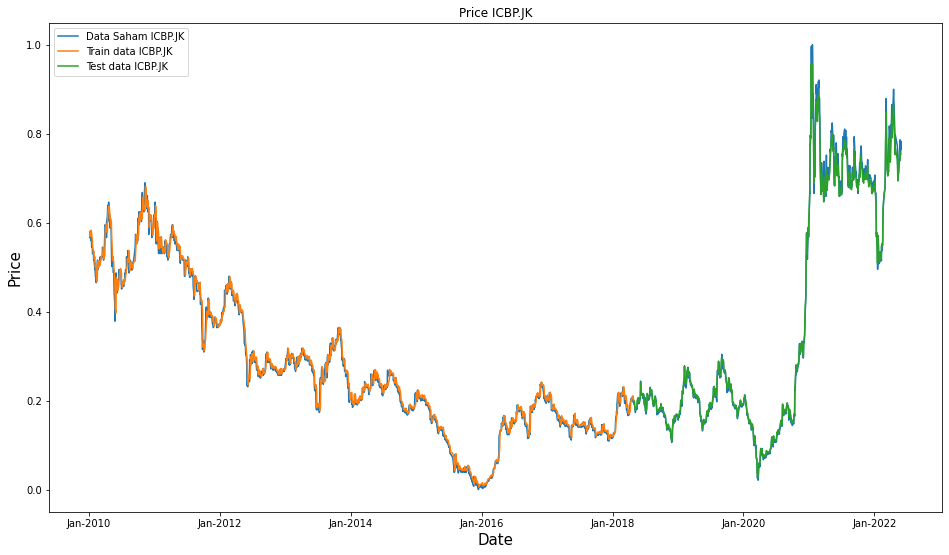

In [51]:
#Date For data
split = int(len(datasetAntm)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ICBP.JK'
ax.plot(all_date,scaler.inverse_transform(datasetAntm), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictAntmOne, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictAntmOne, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

### ASII

#### GETTING DATA

In [238]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ASII.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
panel_data
close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetAsii = dataframe.values
datasetAsii = datasetAsii.astype('float32')
datasetAsii
#print(all_weekdays)


array([[3530.],
       [3550.],
       [3530.],
       ...,
       [7225.],
       [7250.],
       [7350.]], dtype=float32)

#### NORMALIZE DATA

In [239]:
# normalize the datasetASii
scaler = MinMaxScaler(feature_range=(0, 1))
datasetASii = scaler.fit_transform(datasetAsii)
# split into train and test sets
train_size = int(len(datasetASii) * 0.67)
test_size = len(datasetASii) - train_size
trainAsii, testAsii = datasetASii[0:train_size,:], datasetASii[train_size:len(datasetASii),:]


In [240]:
# reshape into X=t and Y=t+1
look_back = 2
trainXAsii, trainYAsii = create_dataset(trainAsii, look_back)
testXAsii, testYAsii = create_dataset(testAsii, look_back)
# reshape input to be [samples, time steps, features]
trainXAsii = np.reshape(trainXAsii, (trainXAsii.shape[0], trainXAsii.shape[1], 1))
testXAsii = np.reshape(testXAsii, (testXAsii.shape[0], testXAsii.shape[1], 1))

#### MODEL DEFINITOIN

In [241]:
# import random
# random.seed(2)
# create and fit the LSTM network
modelAsiiOne = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='relu', input_shape=(look_back, 1)),
tf.keras.layers.Dense(1)
])
modelAsiiOne.summary()
modelAsiiOne.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelAsiiOneHistory = modelAsiiOne.fit(trainXAsii, trainYAsii, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_63 (LSTM)              (None, 64)                16896     
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 2s 10ms/step - loss: 0.4345 - mean_absolute_error: 0.4345 - val_loss: 0.4472 - val_mean_absolute_error: 0.4472
Epoch 2/10
52/52 [==============================] - 0s 5ms/step - loss: 0.1032 - mean_absolute_error: 0.1032 - val_loss: 0.0370 - val_mean_absolute_error: 0.0370
Epoch 3/10
52/52 [==============================] - 0s 4ms/step - loss: 0.0288 - mean_absolute_error: 0.0288 - val_loss:

#### PLOT MODEL LOSS

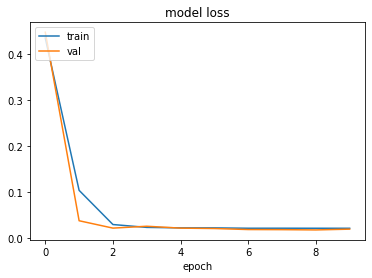

In [242]:
plt.plot(modelAsiiOneHistory.history['loss'])
plt.plot(modelAsiiOneHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [243]:
# make predictions
trainPredictAsiiOne = modelAsiiOne.predict(trainXAsii)
testPredictAsiiOne = modelAsiiOne.predict(testXAsii)
# invert predictions
trainPredictAsiiOne = scaler.inverse_transform(trainPredictAsiiOne)
trainYAsii = scaler.inverse_transform([trainYAsii])
testPredictAsiiOne = scaler.inverse_transform(testPredictAsiiOne)
testYAsii = scaler.inverse_transform([testYAsii])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetAsii)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictAsiiOne)+look_back, :] = trainPredictAsiiOne
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetAsii)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictAsiiOne)+(look_back*2)+1:len(datasetAsii)-1, :] = testPredictAsiiOne

#### MATRIC EVALUATION

In [244]:
from sklearn.metrics import r2_score

print('Asii 1 layer')
# calculate  mean absolute error
trainScoreAsiiOne = mean_absolute_error(trainYAsii[0], trainPredictAsiiOne[:,0])
print('Train Score: %.2f MAE' % (trainScoreAsiiOne))
testScoreAsiiOne = mean_absolute_error(testYAsii[0], testPredictAsiiOne[:,0])
print('Test Score: %.2f MAE' % (testScoreAsiiOne))

r2TrainScoreAsiiOne = r2_score(trainYAsii[0], trainPredictAsiiOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreAsiiOne))
r2TestScoreAsiiOne = r2_score(testYAsii[0], testPredictAsiiOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreAsiiOne))

Asii 1 layer
Train Score: 119.63 MAE
Test Score: 113.82 MAE
Train R2 Score: 0.98 R2 Score
Train R2 Score: 0.98 R2 Score


#### PLOTING FINAL RESULT

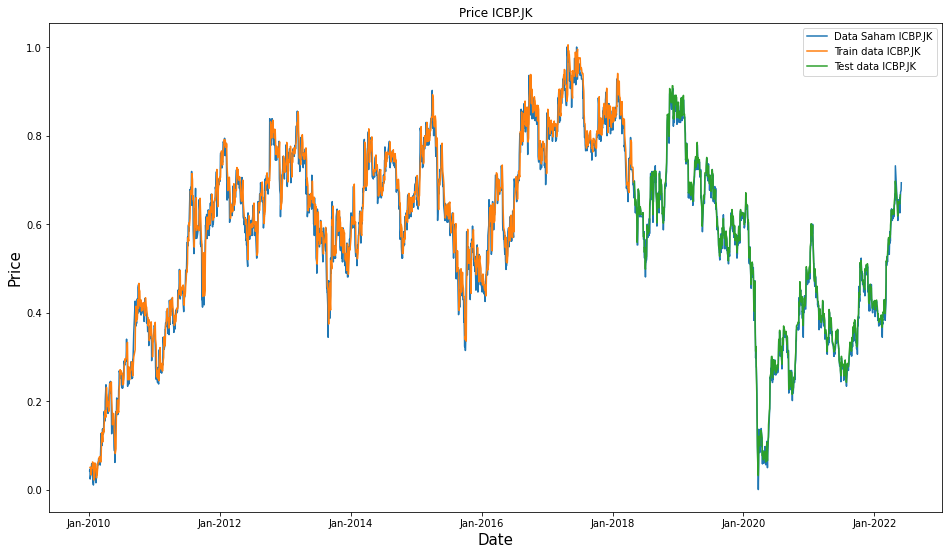

In [80]:
#Date For data
split = int(len(datasetAsii)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ICBP.JK'
ax.plot(all_date,scaler.inverse_transform(datasetAsii), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictAsiiOne, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictAsiiOne, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

### ICBP

#### GET THE DATA

In [228]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ICBP.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
panel_data

close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetIcbp = dataframe.values
datasetIcbp = datasetIcbp.astype('float32')
datasetIcbp
#print(all_weekdays)



array([[1837.5],
       [1875. ],
       [1862.5],
       ...,
       [8625. ],
       [8550. ],
       [8575. ]], dtype=float32)

#### NORMALIZE DATA

In [229]:
# normalize the datasetIcbp
scaler = MinMaxScaler(feature_range=(0, 1))
datasetIcbp = scaler.fit_transform(datasetIcbp)
# split into train and test sets
train_size = int(len(datasetIcbp) * 0.67)
test_size = len(datasetIcbp) - train_size
trainIcbp, testIcbp = datasetIcbp[0:train_size,:], datasetIcbp[train_size:len(datasetIcbp),:]
# reshape into X=t and Y=t+1
look_back = 2
trainXIcbp, trainYIcbp = create_dataset(trainIcbp, look_back)
testXIcbp, testYIcbp = create_dataset(testIcbp, look_back)
# reshape input to be [samples, time steps, features]
trainXIcbp = np.reshape(trainXIcbp, (trainXIcbp.shape[0], trainXIcbp.shape[1], 1))
testXIcbp = np.reshape(testXIcbp, (testXIcbp.shape[0], testXIcbp.shape[1], 1))

#### MODEL DEFINITION 

In [230]:
# import random
# random.seed(2)
# create and fit the LSTM network
modelIcbpOne = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='relu', input_shape=(look_back, 1)),
tf.keras.layers.Dense(1)
])
modelIcbpOne.summary()
modelIcbpOne.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelIcbpOneHistory = modelIcbpOne.fit(trainXIcbp, trainYIcbp, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 64)                16896     
                                                                 
 dense_34 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 2s 11ms/step - loss: 0.1835 - mean_absolute_error: 0.1835 - val_loss: 0.3405 - val_mean_absolute_error: 0.3405
Epoch 2/10
52/52 [==============================] - 0s 4ms/step - loss: 0.0768 - mean_absolute_error: 0.0768 - val_loss: 0.0358 - val_mean_absolute_error: 0.0358
Epoch 3/10
52/52 [==============================] - 0s 4ms/step - loss: 0.0125 - mean_absolute_error: 0.0125 - val_loss:

#### PLOTING MODEL LOSS

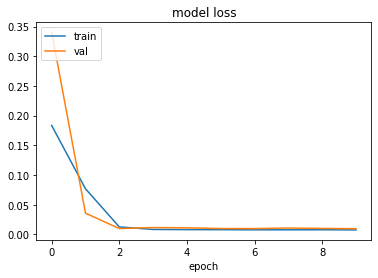

In [231]:
plt.plot(modelIcbpOneHistory.history['loss'])
plt.plot(modelIcbpOneHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [232]:
# make predictions
trainPredictIcbpOne = modelIcbpOne.predict(trainXIcbp)
testPredictIcbpOne = modelIcbpOne.predict(testXIcbp)
# invert predictions
trainPredictIcbpOne = scaler.inverse_transform(trainPredictIcbpOne)
trainYIcbp = scaler.inverse_transform([trainYIcbp])
testPredictIcbpOne = scaler.inverse_transform(testPredictIcbpOne)
testYIcbp = scaler.inverse_transform([testYIcbp])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetIcbp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictIcbpOne)+look_back, :] = trainPredictIcbpOne
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetIcbp)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictIcbpOne)+(look_back*2)+1:len(datasetIcbp)-1, :] = testPredictIcbpOne

#### METRIC EVALUATION

In [234]:
from sklearn.metrics import r2_score

print('icbp 1 layer')
# calculate  mean absolute error
trainScoreIcbpOne = mean_absolute_error(trainYIcbp[0], trainPredictIcbpOne[:,0])
print('Train Score: %.2f MAE' % (trainScoreIcbpOne))
testScoreIcbpOne = mean_absolute_error(testYIcbp[0], testPredictIcbpOne[:,0])
print('Test Score: %.2f MAE' % (testScoreIcbpOne))

r2TrainScoreIcbpOne = r2_score(trainYIcbp[0], trainPredictIcbpOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreIcbpOne))
r2TestScoreIcbpOne = r2_score(testYIcbp[0], testPredictIcbpOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreIcbpOne))

icbp 1 layer
Train Score: 82.78 MAE
Test Score: 126.74 MAE
Train R2 Score: 1.00 R2 Score
Train R2 Score: 0.97 R2 Score


#### PLOT FINAL RESULT

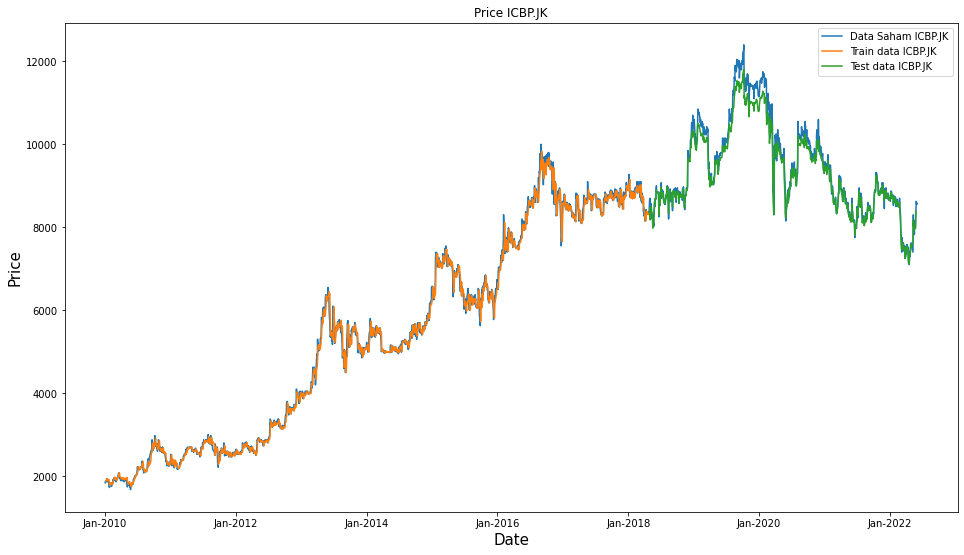

In [108]:
#Date For data
split = int(len(datasetIcbp)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ICBP.JK'
ax.plot(all_date,scaler.inverse_transform(datasetIcbp), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictIcbpOne, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictIcbpOne, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

### JSMR

#### GET THE DATA

In [221]:
#Saham yang akan dimodelkan
#,"ASII.JK","Jsmr.JK","JSMR.JK"
tickers = ["JSMR.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
panel_data

close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetJsmr = dataframe.values
datasetJsmr = datasetJsmr.astype('float32')
datasetJsmr
#print(all_weekdays)

array([[1845.6774],
       [1865.6307],
       [1875.6073],
       ...,
       [3850.    ],
       [4010.    ],
       [4000.    ]], dtype=float32)

#### NORMALIZE DATA

In [222]:
# normalize the datasetJsmr
scaler = MinMaxScaler(feature_range=(0, 1))
datasetJsmr = scaler.fit_transform(datasetJsmr)
# split into train and test sets
train_size = int(len(datasetJsmr) * 0.67)
test_size = len(datasetJsmr) - train_size
trainJsmr, testJsmr = datasetJsmr[0:train_size,:], datasetJsmr[train_size:len(datasetJsmr),:]
# reshape into X=t and Y=t+1
look_back = 2
trainXJsmr, trainYJsmr = create_dataset(trainJsmr, look_back)
testXJsmr, testYJsmr = create_dataset(testJsmr, look_back)
# reshape input to be [samples, time steps, features]
trainXJsmr = np.reshape(trainXJsmr, (trainXJsmr.shape[0], trainXJsmr.shape[1], 1))
testXJsmr = np.reshape(testXJsmr, (testXJsmr.shape[0], testXJsmr.shape[1], 1))

#### MODEL DEFINITION

In [223]:
# import random
# random.seed(2)
# create and fit the LSTM network
modelJsmrOne = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='relu', input_shape=(look_back, 1)),
tf.keras.layers.Dense(1)
])
modelJsmrOne.summary()
modelJsmrOne.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelJsmrOneHistory = modelJsmrOne.fit(trainXJsmr, trainYJsmr, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_61 (LSTM)              (None, 64)                16896     
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 2s 11ms/step - loss: 0.4709 - mean_absolute_error: 0.4709 - val_loss: 0.3850 - val_mean_absolute_error: 0.3850
Epoch 2/10
52/52 [==============================] - 0s 4ms/step - loss: 0.1937 - mean_absolute_error: 0.1937 - val_loss: 0.0242 - val_mean_absolute_error: 0.0242
Epoch 3/10
52/52 [==============================] - 0s 4ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss:

#### PLOT MODEL LOSS

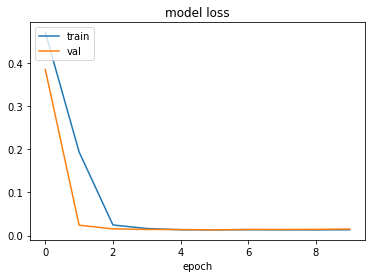

In [224]:
plt.plot(modelJsmrOneHistory.history['loss'])
plt.plot(modelJsmrOneHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [225]:
# make predictions
trainPredictJsmrOne = modelJsmrOne.predict(trainXJsmr)
testPredictJsmrOne = modelJsmrOne.predict(testXJsmr)
# invert predictions
trainPredictJsmrOne = scaler.inverse_transform(trainPredictJsmrOne)
trainYJsmr = scaler.inverse_transform([trainYJsmr])
testPredictJsmrOne = scaler.inverse_transform(testPredictJsmrOne)
testYJsmr = scaler.inverse_transform([testYJsmr])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetJsmr)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictJsmrOne)+look_back, :] = trainPredictJsmrOne
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetJsmr)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictJsmrOne)+(look_back*2)+1:len(datasetJsmr)-1, :] = testPredictJsmrOne

#### METRIC EVALUATION

In [227]:
from sklearn.metrics import r2_score

print('jsmr 1 layer')
# calculate  mean absolute error
trainScoreJsmrOne = mean_absolute_error(trainYJsmr[0], trainPredictJsmrOne[:,0])
print('Train Score: %.2f MAE' % (trainScoreJsmrOne))
testScoreJsmrOne = mean_absolute_error(testYJsmr[0], testPredictJsmrOne[:,0])
print('Test Score: %.2f MAE' % (testScoreJsmrOne))

r2TrainScoreJsmrOne = r2_score(trainYJsmr[0], trainPredictJsmrOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreJsmrOne))
r2TestScoreJsmrOne = r2_score(testYJsmr[0], testPredictJsmrOne[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreJsmrOne))

jsmr 1 layer
Train Score: 80.73 MAE
Test Score: 98.63 MAE
Train R2 Score: 0.99 R2 Score
Train R2 Score: 0.97 R2 Score


#### PLOTING FINAL RESULT

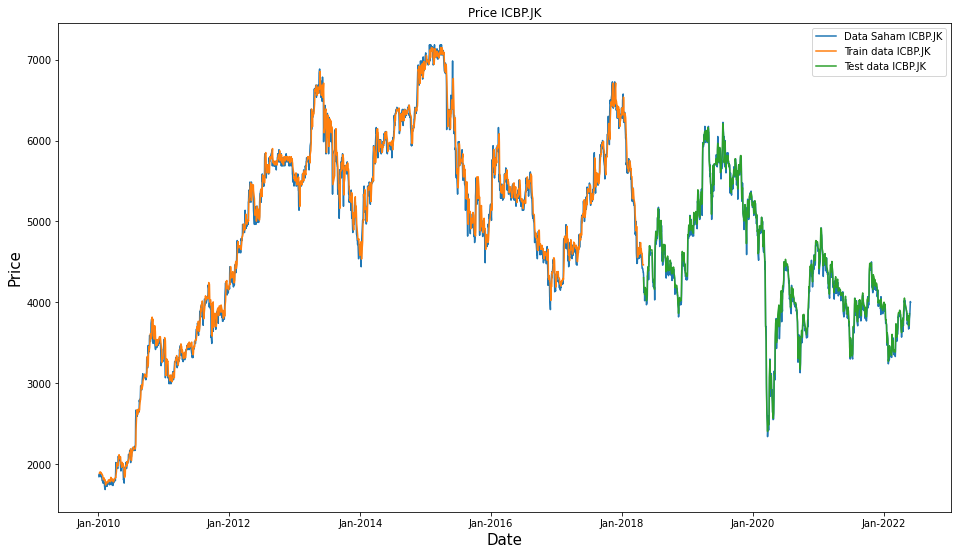

In [118]:
#Date For data
split = int(len(datasetJsmr)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ICBP.JK'
ax.plot(all_date,scaler.inverse_transform(datasetJsmr), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictJsmrOne, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictJsmrOne, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

## LSTM THREE LAYER

### ANTM

#### GET DATA

In [214]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ANTM.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetAntm = dataframe.values
datasetAntm = datasetAntm.astype('float32')
datasetAntm
#print(all_weekdays)



array([[1931.9468],
       [1931.9468],
       [1931.9468],
       ...,
       [2470.    ],
       [2560.    ],
       [2510.    ]], dtype=float32)

In [215]:
# normalize the datasetAntm
scaler = MinMaxScaler(feature_range=(0, 1))
datasetAntm = scaler.fit_transform(datasetAntm)
# split into train and test sets
train_size = int(len(datasetAntm) * 0.67)
test_size = len(datasetAntm) - train_size
train_antm, test_antm = datasetAntm[0:train_size,:], datasetAntm[train_size:len(datasetAntm),:]

In [216]:
# reshape into X=t and Y=t+1
look_back = 2
trainXAntm, trainYAntm = create_dataset(train_antm, look_back)
testXAntm, testYAntm = create_dataset(test_antm, look_back)
# reshape input to be [samples, time steps, features]
trainXAntm = np.reshape(trainXAntm, (trainXAntm.shape[0], trainXAntm.shape[1], 1))
testXAntm = np.reshape(testXAntm, (testXAntm.shape[0], testXAntm.shape[1], 1))

#### MODEL DEFINITION

In [217]:
import random
random.seed(2)
# create and fit the LSTM network

modelAntmThree = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='tanh', input_shape=(look_back, 1),return_sequences=True),
tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True),
tf.keras.layers.LSTM(64,activation='tanh'),
tf.keras.layers.Dense(1)
])
modelAntmThree.summary()
modelAntmThree.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelAntmThreeHistory = modelAntmThree.fit(trainXAntm, trainYAntm, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 2, 64)             16896     
                                                                 
 lstm_59 (LSTM)              (None, 2, 64)             33024     
                                                                 
 lstm_60 (LSTM)              (None, 64)                33024     
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 9s 37ms/step - loss: 0.1493 - mean_absolute_error: 0.1493 - val_loss: 0.0714 - val_mean_absolute_error: 0.0714
Epoch 2/10
52/52 [

#### PLOTING MODEL LOSs

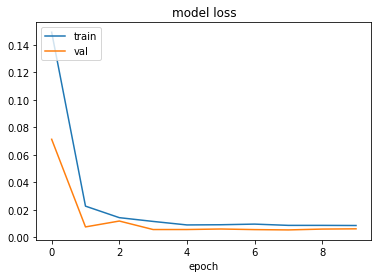

In [218]:
plt.plot(modelAntmThreeHistory.history['loss'])
plt.plot(modelAntmThreeHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [219]:
# make predictions
trainPredictAntmThree = modelAntmThree.predict(trainXAntm)
testPredictAntmThree = modelAntmThree.predict(testXAntm)
# invert predictions
trainPredictAntmThree = scaler.inverse_transform(trainPredictAntmThree)
trainYAntm = scaler.inverse_transform([trainYAntm])
testPredictAntmThree = scaler.inverse_transform(testPredictAntmThree)
testYAntm = scaler.inverse_transform([testYAntm])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetAntm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictAntmThree)+look_back, :] = trainPredictAntmThree
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetAntm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictAntmThree)+(look_back*2)+1:len(datasetAntm)-1, :] = testPredictAntmThree

#### METRIC EVALUATION

In [220]:
from sklearn.metrics import r2_score

print('antm 3 layer')
# calculate  mean absolute error
trainScoreAntmThree = mean_absolute_error(trainYAntm[0], trainPredictAntmThree[:,0])
print('Train Score: %.2f MAE' % (trainScoreAntmThree))
testScoreAntmThree = mean_absolute_error(testYAntm[0], testPredictAntmThree[:,0])
print('Test Score: %.2f MAE' % (testScoreAntmThree))

r2TrainScoreAntmThree = r2_score(trainYAntm[0], trainPredictAntmThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreAntmThree))
r2TestScoreAntmThree = r2_score(testYAntm[0], testPredictAntmThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreAntmThree))

antm 3 layer
Train Score: 24.41 MAE
Test Score: 44.19 MAE
Train R2 Score: 0.99 R2 Score
Train R2 Score: 0.99 R2 Score


#### PLOTING FINAL RESULT

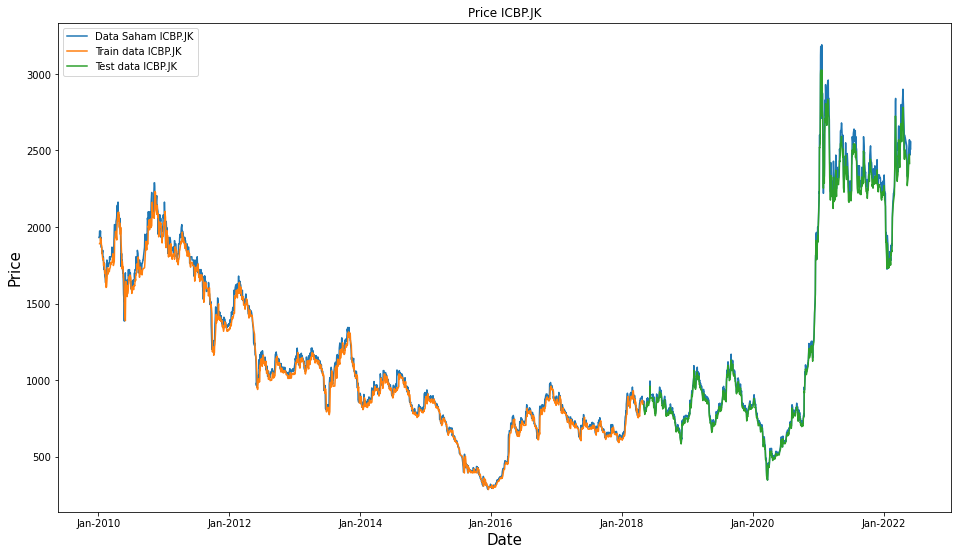

In [136]:
#Date For data
split = int(len(datasetAntm)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ICBP.JK'
ax.plot(all_date,scaler.inverse_transform(datasetAntm), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictAntmThree, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictAntmThree, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

### ASII

#### GET DATA

In [205]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ASII.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today


In [206]:

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetAsii = dataframe.values
datasetAsii = datasetAsii.astype('float32')
datasetAsii
#print(all_weekdays)



array([[3530.],
       [3550.],
       [3530.],
       ...,
       [7225.],
       [7250.],
       [7350.]], dtype=float32)

In [207]:
# normalize the datasetAsii
scaler = MinMaxScaler(feature_range=(0, 1))
datasetAsii = scaler.fit_transform(datasetAsii)
# split into train and test sets
train_size = int(len(datasetAsii) * 0.67)
test_size = len(datasetAsii) - train_size
train_Asii, test_Asii = datasetAsii[0:train_size,:], datasetAsii[train_size:len(datasetAsii),:]

In [208]:
# reshape into X=t and Y=t+1
look_back = 2
trainXAsii, trainYAsii = create_dataset(train_Asii, look_back)
testXAsii, testYAsii = create_dataset(test_Asii, look_back)
# reshape input to be [samples, time steps, features]
trainXAsii = np.reshape(trainXAsii, (trainXAsii.shape[0], trainXAsii.shape[1], 1))
testXAsii = np.reshape(testXAsii, (testXAsii.shape[0], testXAsii.shape[1], 1))

#### MODEL DEF

In [209]:
import random
random.seed(2)
# create and fit the LSTM network

modelAsiiThree = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='tanh', input_shape=(look_back, 1),return_sequences=True),
tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True),
tf.keras.layers.LSTM(64,activation='tanh'),
tf.keras.layers.Dense(1)
])
modelAsiiThree.summary()
modelAsiiThree.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelAsiiThreeHistory = modelAsiiThree.fit(trainXAsii, trainYAsii, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 2, 64)             16896     
                                                                 
 lstm_56 (LSTM)              (None, 2, 64)             33024     
                                                                 
 lstm_57 (LSTM)              (None, 64)                33024     
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 9s 40ms/step - loss: 0.2572 - mean_absolute_error: 0.2572 - val_loss: 0.0597 - val_mean_absolute_error: 0.0597
Epoch 2/10
52/52 [

#### PLOT MODEL LOSS

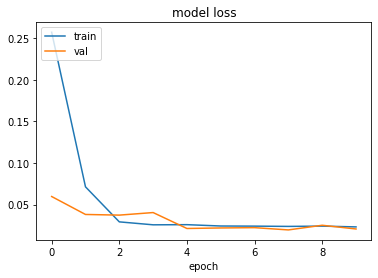

In [210]:
plt.plot(modelAsiiThreeHistory.history['loss'])
plt.plot(modelAsiiThreeHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [211]:
# make predictions
trainPredictAsiiThree = modelAsiiThree.predict(trainXAsii)
testPredictAsiiThree = modelAsiiThree.predict(testXAsii)
# invert predictions
trainPredictAsiiThree = scaler.inverse_transform(trainPredictAsiiThree)
trainYAsii = scaler.inverse_transform([trainYAsii])
testPredictAsiiThree = scaler.inverse_transform(testPredictAsiiThree)
testYAsii = scaler.inverse_transform([testYAsii])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetAsii)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictAsiiThree)+look_back, :] = trainPredictAsiiThree
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetAsii)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictAsiiThree)+(look_back*2)+1:len(datasetAsii)-1, :] = testPredictAsiiThree

#### METRIC EVALUATION

In [213]:
from sklearn.metrics import r2_score


print('ASII 3 layer')
# calculate  mean absolute error
trainScoreAsiiThree = mean_absolute_error(trainYAsii[0], trainPredictAsiiThree[:,0])
print('Train Score: %.2f MAE' % (trainScoreAsiiThree))
testScoreAsiiThree = mean_absolute_error(testYAsii[0], testPredictAsiiThree[:,0])
print('Test Score: %.2f MAE' % (testScoreAsiiThree))

r2TrainScoreAsiiThree = r2_score(trainYAsii[0], trainPredictAsiiThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreAsiiThree))
r2TestScoreAsiiThree = r2_score(testYAsii[0], testPredictAsiiThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreAsiiThree))

ASII 3 layer
Train Score: 131.90 MAE
Test Score: 118.55 MAE
Train R2 Score: 0.98 R2 Score
Train R2 Score: 0.98 R2 Score


#### PLOTING FINAL RESULT

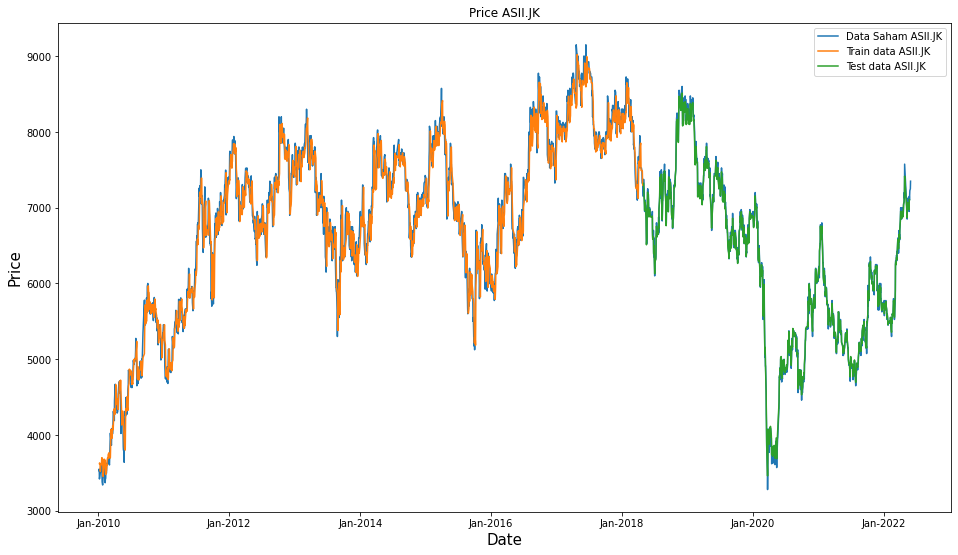

In [146]:
#Date For data
split = int(len(datasetAsii)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ASII.JK'
ax.plot(all_date,scaler.inverse_transform(datasetAsii), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictAsiiThree, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictAsiiThree, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

### ICBP

#### GET DATA

In [197]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ICBP.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today


In [198]:

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetIcbp = dataframe.values
datasetIcbp = datasetIcbp.astype('float32')
datasetIcbp
#print(all_weekdays)



array([[1837.5],
       [1875. ],
       [1862.5],
       ...,
       [8625. ],
       [8550. ],
       [8575. ]], dtype=float32)

In [199]:
# normalize the datasetIcbp
scaler = MinMaxScaler(feature_range=(0, 1))
datasetIcbp = scaler.fit_transform(datasetIcbp)
# split into train and test sets
train_size = int(len(datasetIcbp) * 0.67)
test_size = len(datasetIcbp) - train_size
train_Icbp, test_Icbp = datasetIcbp[0:train_size,:], datasetIcbp[train_size:len(datasetIcbp),:]

In [200]:
# reshape into X=t and Y=t+1
look_back = 2
trainXIcbp, trainYIcbp = create_dataset(train_Icbp, look_back)
testXIcbp, testYIcbp = create_dataset(test_Icbp, look_back)
# reshape input to be [samples, time steps, features]
trainXIcbp = np.reshape(trainXIcbp, (trainXIcbp.shape[0], trainXIcbp.shape[1], 1))
testXIcbp = np.reshape(testXIcbp, (testXIcbp.shape[0], testXIcbp.shape[1], 1))

#### MODEL DEFINITION

In [201]:
import random
random.seed(2)
# create and fit the LSTM network

modelIcbpThree = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='tanh', input_shape=(look_back, 1),return_sequences=True),
tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True),
tf.keras.layers.LSTM(64,activation='tanh'),
tf.keras.layers.Dense(1)
])
modelIcbpThree.summary()
modelIcbpThree.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelIcbpThreeHistory = modelIcbpThree.fit(trainXIcbp, trainYIcbp, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_52 (LSTM)              (None, 2, 64)             16896     
                                                                 
 lstm_53 (LSTM)              (None, 2, 64)             33024     
                                                                 
 lstm_54 (LSTM)              (None, 64)                33024     
                                                                 
 dense_30 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 9s 37ms/step - loss: 0.1492 - mean_absolute_error: 0.1492 - val_loss: 0.0128 - val_mean_absolute_error: 0.0128
Epoch 2/10
52/52 [

#### PLOT MODEL LOSS

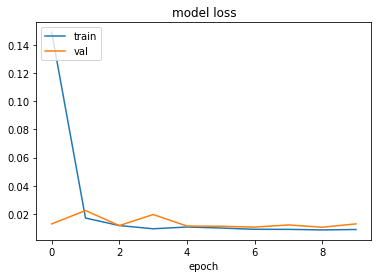

In [202]:
plt.plot(modelIcbpThreeHistory.history['loss'])
plt.plot(modelIcbpThreeHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [203]:
# make predictions
trainPredictIcbpThree = modelIcbpThree.predict(trainXIcbp)
testPredictIcbpThree = modelIcbpThree.predict(testXIcbp)
# invert predictions
trainPredictIcbpThree = scaler.inverse_transform(trainPredictIcbpThree)
trainYIcbp = scaler.inverse_transform([trainYIcbp])
testPredictIcbpThree = scaler.inverse_transform(testPredictIcbpThree)
testYIcbp = scaler.inverse_transform([testYIcbp])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetIcbp)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictIcbpThree)+look_back, :] = trainPredictIcbpThree
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetIcbp)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictIcbpThree)+(look_back*2)+1:len(datasetIcbp)-1, :] = testPredictIcbpThree

#### METRIC EVALUTAION

In [204]:
from sklearn.metrics import r2_score

print("ICBP 3 layer")
# calculate  mean absolute error
trainScoreIcbpThree = mean_absolute_error(trainYIcbp[0], trainPredictIcbpThree[:,0])
print('Train Score: %.2f MAE' % (trainScoreIcbpThree))
testScoreIcbpThree = mean_absolute_error(testYIcbp[0], testPredictIcbpThree[:,0])
print('Test Score: %.2f MAE' % (testScoreIcbpThree))

r2TrainScoreIcbpThree = r2_score(trainYIcbp[0], trainPredictIcbpThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreIcbpThree))
r2TestScoreIcbpThree = r2_score(testYIcbp[0], testPredictIcbpThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreIcbpThree))

ICBP 3 layer
Train Score: 103.32 MAE
Test Score: 185.85 MAE
Train R2 Score: 1.00 R2 Score
Train R2 Score: 0.95 R2 Score


#### PLOTING FINAL RESULT

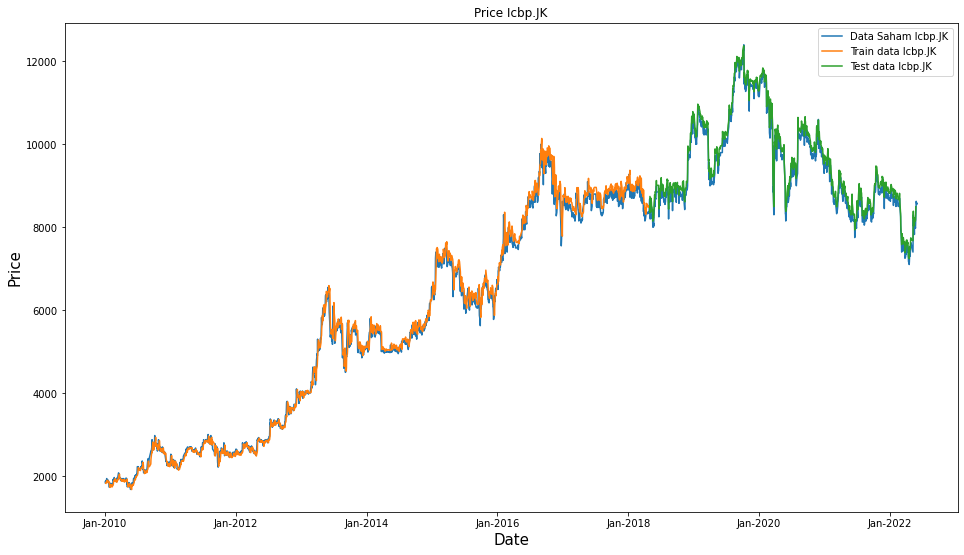

In [160]:
#Date For data
split = int(len(datasetIcbp)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'Icbp.JK'
ax.plot(all_date,scaler.inverse_transform(datasetIcbp), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictIcbpThree, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictIcbpThree, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()

### JSMR

#### GET DATA

In [185]:
#Saham yang akan dimodelkan
#,"ASII.JK","JSMR.JK","JSMR.JK"
tickers = ["JSMR.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-05-31'
# end_date = today


In [187]:

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
close = panel_data["Close"]
all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')
close = close.reindex(all_weekdays)
close = close.dropna()
dataframe = close
datasetJsmr = dataframe.values
datasetJsmr = datasetJsmr.astype('float32')
datasetJsmr
#print(all_weekdays)



array([[1845.6774],
       [1865.6307],
       [1875.6073],
       ...,
       [3850.    ],
       [4010.    ],
       [4000.    ]], dtype=float32)

In [188]:
# normalize the datasetJsmr
scaler = MinMaxScaler(feature_range=(0, 1))
datasetJsmr = scaler.fit_transform(datasetJsmr)
# split into train and test sets
train_size = int(len(datasetJsmr) * 0.67)
test_size = len(datasetJsmr) - train_size
train_Jsmr, test_Jsmr = datasetJsmr[0:train_size,:], datasetJsmr[train_size:len(datasetJsmr),:]

In [189]:
# reshape into X=t and Y=t+1
look_back = 2
trainXJsmr, trainYJsmr = create_dataset(train_Jsmr, look_back)
testXJsmr, testYJsmr = create_dataset(test_Jsmr, look_back)
# reshape input to be [samples, time steps, features]
trainXJsmr = np.reshape(trainXJsmr, (trainXJsmr.shape[0], trainXJsmr.shape[1], 1))
testXJsmr = np.reshape(testXJsmr, (testXJsmr.shape[0], testXJsmr.shape[1], 1))

#### MODEL DEF

In [190]:
import random
random.seed(2)
# create and fit the LSTM network

modelJsmrThree = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='tanh', input_shape=(look_back, 1),return_sequences=True),
tf.keras.layers.LSTM(64, activation='tanh',return_sequences=True),
tf.keras.layers.LSTM(64,activation='tanh'),
tf.keras.layers.Dense(1)
])
modelJsmrThree.summary()
modelJsmrThree.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

EPOCHS = 10
modelJsmrThreeHistory = modelJsmrThree.fit(trainXJsmr, trainYJsmr, epochs=EPOCHS, batch_size=32, validation_split=0.2)


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)              (None, 2, 64)             16896     
                                                                 
 lstm_50 (LSTM)              (None, 2, 64)             33024     
                                                                 
 lstm_51 (LSTM)              (None, 64)                33024     
                                                                 
 dense_29 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
52/52 [==============================] - 7s 34ms/step - loss: 0.2808 - mean_absolute_error: 0.2808 - val_loss: 0.0859 - val_mean_absolute_error: 0.0859
Epoch 2/10
52/52 [

#### MODEL LOSS

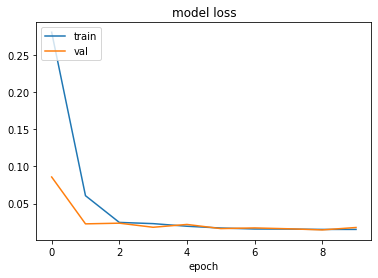

In [191]:
plt.plot(modelJsmrThreeHistory.history['loss'])
plt.plot(modelJsmrThreeHistory.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig(model_latih)
plt.show()

In [192]:
# make predictions
trainPredictJsmrThree = modelJsmrThree.predict(trainXJsmr)
testPredictJsmrThree = modelJsmrThree.predict(testXJsmr)
# invert predictions
trainPredictJsmrThree = scaler.inverse_transform(trainPredictJsmrThree)
trainYJsmr = scaler.inverse_transform([trainYJsmr])
testPredictJsmrThree = scaler.inverse_transform(testPredictJsmrThree)
testYJsmr = scaler.inverse_transform([testYJsmr])

# shift train predictions for plotting
trainPredictPlot = np.empty_like(datasetJsmr)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredictJsmrThree)+look_back, :] = trainPredictJsmrThree
# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetJsmr)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredictJsmrThree)+(look_back*2)+1:len(datasetJsmr)-1, :] = testPredictJsmrThree

#### METRIC EVALUTAION

In [195]:
from sklearn.metrics import r2_score

print('jsmr 3 layer')
# calculate  mean absolute error
trainScoreJsmrThree = mean_absolute_error(trainYJsmr[0], trainPredictJsmrThree[:,0])
print('Train Score: %.2f MAE' % (trainScoreJsmrThree))
testScoreJsmrThree = mean_absolute_error(testYJsmr[0], testPredictJsmrThree[:,0])
print('Test Score: %.2f MAE' % (testScoreJsmrThree))

r2TrainScoreJsmrThree = r2_score(trainYJsmr[0], trainPredictJsmrThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScoreJsmrThree))
r2TestScoreJsmrThree = r2_score(testYJsmr[0], testPredictJsmrThree[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScoreJsmrThree))

jsmr 3 layer
Train Score: 92.08 MAE
Test Score: 111.44 MAE
Train R2 Score: 0.99 R2 Score
Train R2 Score: 0.96 R2 Score


#### PLOTING FINAL RESULT

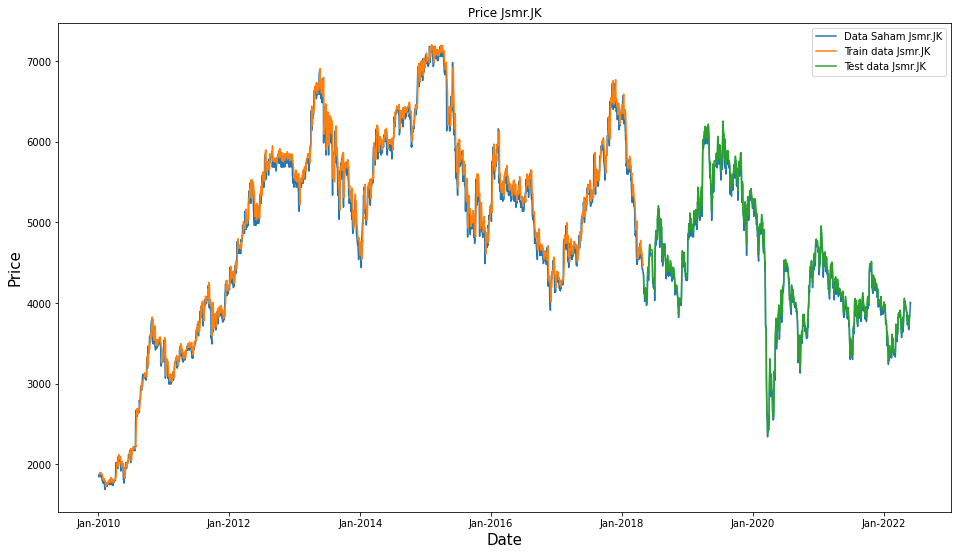

In [194]:
#Date For data
split = int(len(datasetJsmr)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]



# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'Jsmr.JK'
ax.plot(all_date,scaler.inverse_transform(datasetJsmr), label = "Data Saham {}".format(lb_saham))
ax.plot(date_train[look_back+1:],trainPredictJsmrThree, label = "Train data {}".format(lb_saham))
ax.plot(date_test[:-look_back-1],testPredictJsmrThree, label = "Test data {}".format(lb_saham))
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
# plt.savefig(model_latih+'plot')
plt.show()